In [1]:
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = (8, 7)
    plt.style.use('fivethirtyeight')

    import warnings
    warnings.filterwarnings('ignore')

    import yfinance as yf

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (roc_auc_score
                                 , precision_score
                                 , recall_score
                                 , roc_curve
                                 , confusion_matrix
                                 , plot_confusion_matrix
                                 , precision_recall_curve
                                 , auc
                                )

### Global Variables

In [2]:
interval = '1wk'
history = 'max'
perc_inc = 0.018
symbol = 'IYW'
perc_train = 0.15
load_new = 1
current = 0

In [3]:
if interval == '1d' or interval == '1wk':
    index_col = 'Date'
else:
    index_col = 'Datetime'

In [4]:
stock_df = yf.download(tickers = symbol # symbol of stock 

                           , period = history # length of history back in time

                           , interval = interval # time periods of subinterval e.g. 1m or 1hr

                           # , start = start # start date, time

                           # , end = end # end date, time

                           , prepost = True # pre/post market data
                          )
stock_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-15,111.06250,111.06250,109.75000,109.750000,96.253326,20000.0
2000-05-22,106.00000,110.46875,99.50000,105.625000,92.635590,66700.0
2000-05-29,109.00000,125.25000,109.00000,124.750000,109.408676,12100.0
2000-06-05,123.75000,127.62500,122.00000,127.250000,111.601227,28400.0
2000-06-12,126.28125,126.75000,121.03125,125.921875,110.436424,14000.0


In [5]:
def direction(interval = interval
              , history = history
              , perc_inc = perc_inc
              , symbol = symbol
              , perc_train = perc_train
              , load_new = load_new 
              , current = current
             ):
    
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = (8, 7)
    plt.style.use('fivethirtyeight')

    import warnings
    warnings.filterwarnings('ignore')

    import yfinance as yf

    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import (roc_auc_score
                                 , precision_score
                                 , recall_score
                                 , roc_curve
                                 , confusion_matrix
                                 , plot_confusion_matrix
                                 , precision_recall_curve
                                 , auc
                                )
    
    # Load New From Server
    if load_new == 1:
        stock_df = yf.download(tickers = symbol # symbol of stock 

                           , period = history # length of history back in time

                           , interval = interval # time periods of subinterval e.g. 1m or 1hr

                           # , start = start # start date, time

                           # , end = end # end date, time

                           , prepost = True # pre/post market data
                          )
        # Create Percent Change
        stock_df['percent change'] = (stock_df.Open - stock_df.Close) / stock_df.Open

        #create decision column
        stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc

                                        , 1  # 1 if up % or greater

                                        , 0  # 0 if not up % or greater

                                       )
        # create one offs
        decisions = stock_df.decision.values
        decisions = decisions[1:len(decisions)]
        stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
        stock_df_one_off['decision'] = decisions

        # Save DF to CSV
        stock_df.to_csv('stock_df.csv')
        
    else:
        if interval == '1d':
            index_col = 'Date'
        else:
            index_col = 'Datetime'
   
        stock_df = pd.read_csv('stock_df.csv', index_col=index_col)
    
        # create one offs
        decisions = stock_df.decision.values
        decisions = decisions[1:len(decisions)]
        stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1]
        stock_df_one_off['decision'] = decisions
 
    # balance the data
    ones = stock_df_one_off.decision.value_counts()[1]
    stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)
    
    # check for NaN's
    stock_df_bal.dropna(axis=0, inplace=True)
    
    # Train Test Split
    X = stock_df_bal.drop(columns=['percent change', 'decision']) # get columns other than decision
    y = stock_df_bal['decision'] # get decision column
    
    X_train, X_test, y_train, y_test = train_test_split(X
                                                        , y
                                                        , test_size=0.20
                                                        , random_state = 42
                                                       )
    
    # random forest classifier rfc
    rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train)) # odd number 
                                 , max_depth = 3
                                 , max_features = 4
                                 , random_state = 42
                                 , verbose=0 # no showing backend work
                                 , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                                )
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    y_probs = rfc.predict_proba(X_test)[:, 1]
    
    # ROC Value
    roc_value = roc_auc_score(y_test
                              , y_probs
                             )
    
    # AUC Score
    rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
    auc_value = round(auc(rf_recall, rf_prec), 3)
    
    # Feature Importances
    # feature_df = pd.DataFrame({'feature': X_train.columns
    #                            , 'importances': rfc.feature_importances_
    #                           }
    #                          ).sort_values('importances', ascending=False)
    
    # Current = 1 uses most up to date data, = 0 for one pervious current data
    if current == 1:
        loc = -1
    else:
        loc = -2
        
    # Prediction
    last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].iloc[loc]
    if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
        result = f'Buy {symbol} on the {interval} interval for {round(perc_inc *100, 1)}% increase.'
    else:
        result = f'Sell or hold {symbol} on the {interval} interval.'
        
    return ones, roc_value, auc_value, result

In [6]:
ones, roc, auc, result = direction(interval = interval
                                   , history = history
                                   , perc_inc = perc_inc
                                   , symbol = symbol
                                   , perc_train = perc_train
                                   , load_new = load_new 
                                   , current = current
                                  )
print(f'Positives: {ones}')
print(f'ROC Score: {round(roc, 2)}')
print(f'AUC Score: {round(auc, 2)}')
print(result)

[*********************100%***********************]  1 of 1 completed
Positives: 264
ROC Score: 0.58
AUC Score: 0.6
Sell or hold IYW on the 1wk interval.


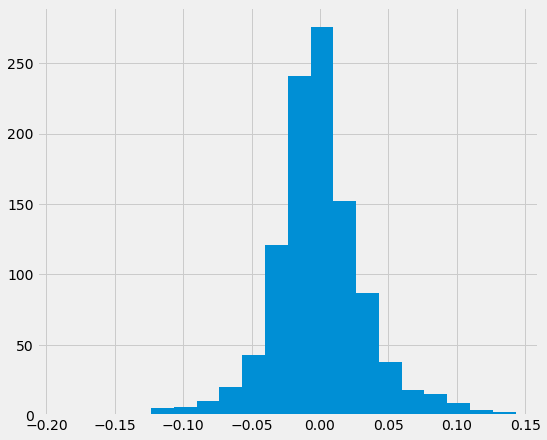

In [7]:
stock_df = pd.read_csv('stock_df.csv', index_col=index_col) # 'Date' for 1d, 'Datetime' for 60m
stock_df['percent change'].hist(bins=20)

In [8]:
stock_df['percent change'].quantile([0.84])

0.84    0.027002
Name: percent change, dtype: float64

In [9]:
perc = [x*0.01 for x in range(5,105, 5)]
perc

[0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.85,
 0.9,
 0.9500000000000001,
 1.0]

In [10]:
roc_lst = []
auc_lst = []
results_lst = []
perc = [x*0.01 for x in range(5,105, 5)]

for x in perc:
    ones, roc, auc, result = direction(interval = interval
                                       , history = history
                                       , perc_inc = perc_inc
                                       , symbol = symbol
                                       , perc_train = x
                                       , load_new = 1
                                       , current = current
                                      )
    roc_lst.append(roc)
    auc_lst.append(auc)
    results_lst.append(result)

results_df = pd.DataFrame({'Percent': perc
                           , 'ROC': roc_lst
                           , 'AUC': auc_lst
                           , 'Result': results_lst
                          }
                         )

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [11]:
results_df

,Percent,ROC,AUC,Result
0,0.05,0.488601,0.496,Buy IYW on the 1wk interval for 1.8% increase.
1,0.10,0.569937,0.580,Buy IYW on the 1wk interval for 1.8% increase.
2,0.15,0.522262,0.582,Buy IYW on the 1wk interval for 1.8% increase.
3,0.20,0.619170,0.620,Buy IYW on the 1wk interval for 1.8% increase.
4,0.25,0.437601,0.531,Sell or hold IYW on the 1wk interval.
5,0.30,0.562425,0.552,Buy IYW on the 1wk interval for 1.8% increase.
6,0.35,0.560142,0.575,Sell or hold IYW on the 1wk interval.
7,0.40,0.631844,0.603,Sell or hold IYW on the 1wk interval.
8,0.45,0.578027,0.581,Buy IYW on the 1wk interval for 1.8% increase.
9,0.50,0.403892,0.465,Buy IYW on the 1wk interval for 1.8% increase.


In [12]:
results_df.Result.value_counts()

Buy IYW on the 1wk interval for 1.8% increase.    13
Sell or hold IYW on the 1wk interval.              7
Name: Result, dtype: int64

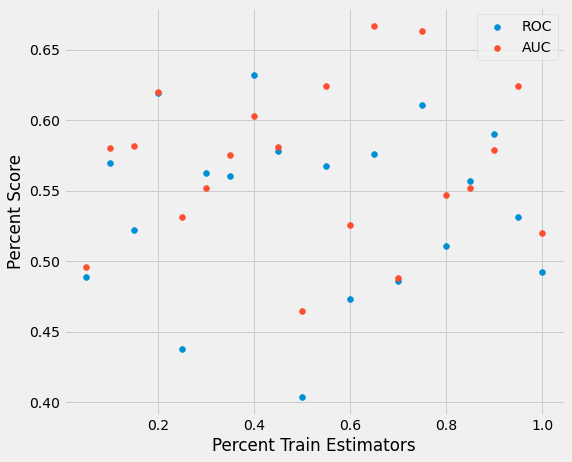

In [13]:
plt.scatter(results_df.Percent
            , results_df.ROC
            , label = 'ROC'
           )
plt.scatter(results_df.Percent
            , results_df.AUC
            , label = 'AUC'
           )
plt.xlabel('Percent Train Estimators')
plt.ylabel('Percent Score')
plt.legend();


In [14]:
results_df.loc[results_df.ROC == results_df.ROC.max()]

,Percent,ROC,AUC,Result
7,0.4,0.631844,0.603,Sell or hold IYW on the 1wk interval.


In [15]:
results_df.loc[results_df.ROC == results_df.ROC.max()].Percent.iloc[0]

0.4

In [16]:
ones, roc, auc, result = direction(interval = interval
                                   , history = history
                                   , perc_inc = 0.018
                                   , symbol = symbol
                                   , perc_train = results_df.loc[results_df.ROC == results_df.ROC.max()].Percent.iloc[0]
                                   , current = 1
                                  )
print(f'Positives: {ones}')
print(f'ROC Score: {round(roc, 2)}')
print(f'AUC Score: {round(auc, 2)}')
print(result)

[*********************100%***********************]  1 of 1 completed
Positives: 264
ROC Score: 0.65
AUC Score: 0.7
Buy IYW on the 1wk interval for 1.8% increase.


In [17]:
stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Date,,,,,,,,
2020-06-08,259.880005,269.420013,251.440002,255.570007,255.127014,746100.0,0.016585,1
2020-06-15,250.369995,268.450012,250.350006,264.230011,263.772003,517800.0,-0.055358,0
2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-06-22,264.470001,273.350006,261.010010,261.529999,261.529999,780400.0,0.011117,0
2020-06-26,266.880005,267.359985,261.010010,261.529999,261.529999,96539.0,0.020046,0


### Losses and Recovery

In [18]:
losses_df = pd.DataFrame({'Loss %': [0.01 * x for x in range(1,21,1)]
                          , 'Needed Gain %': [1/(1-0.01*x)-1 for x in range(1,21,1)]
                          , '% Difference': [(1/(1-0.01*x)-1-0.01*x)/(0.01*x)*100 for x in range(1,21,1)]
                         }
                        )
losses_df

,Loss %,Needed Gain %,% Difference
0,0.01,0.010101,1.010101
1,0.02,0.020408,2.040816
2,0.03,0.030928,3.092784
3,0.04,0.041667,4.166667
4,0.05,0.052632,5.263158
5,0.06,0.063830,6.382979
6,0.07,0.075269,7.526882
7,0.08,0.086957,8.695652
8,0.09,0.098901,9.890110
9,0.10,0.111111,11.111111
